# GeoDistance check of OWDs - automatic

In [1]:
%matplotlib inline

import requests
import math

try: import simplejson as json
except ImportError: import json

from elasticsearch import Elasticsearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
my_index = "network_weather-*"

my_query = {}
OWDpos={}

In [3]:
query={
   "size": 0,
   "query": {
    "bool": {
      "must": [
        {"term": { "_type" : "latency"}}
      ],
      "filter" : {
        'range': {'timestamp': {'gte': '20161111T000000+0000'}}
      }
    }
   },
    "aggs" : {
      "src" : {
        "terms" : { "field" : "src", "size": 1000 },
        "aggs" : {
          "dest" : {
            "terms" : {"field" : "dest", "size": 1000},
            "aggs" : {
              "avgde" : {
                "avg" :{ "field" : "delay_mean" }
              }
          }
        }
      }
    }
    }        
}

res = es.search(index=my_index, body=query, request_timeout=120)

In [4]:
def getServerLongLat(ip):
    
    if ip in OWDpos:
        return OWDpos[ip]
    
    try:
        req = requests.get("http://geoip.mwt2.org:4288/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        pass
#         print ("Can't determine coordinates. Trying next one.", ip)
        
    try:
        req = requests.get("http://freegeoip.net/json/"+ip, None)
        res=req.json()
        lon=res['longitude']
        lat=res['latitude']
        pos=[lon,lat]
        OWDpos[ip]=pos
        return pos
    except:
        print ("Can't determine coordinates", ip)
        
def getDistance(ip1,ip2):
    p1=getServerLongLat(ip1)
    p2=getServerLongLat(ip2)
    if not p1 or not p2: return 0.0
    dlon = math.radians(p1[0] - p2[0])
    dlat = math.radians(p1[1] - p2[1])
    a = pow(math.sin(dlat/2),2) + math.cos(math.radians(p2[1])) * math.cos(math.radians(p1[1])) * pow(math.sin(dlon/2),2)
    c = 2 * math.atan2( math.sqrt(a), math.sqrt(1-a) )
    d = 6373 * c # 6373 is the radius of the Earth in km
    return d  

  Creating DataFrame with all the data        

In [5]:
ser = res['aggregations']['src']['buckets']
count=10
src=[]
dest=[]
docs=[]
dist=[]
owd=[]
for s in ser:
    des=s['dest']['buckets']
    for d in des:
        delay = d['avgde']['value']
        distance = getDistance(s['key'], d['key'])
        
        src.append( s['key'])
        dest.append(d['key'])
        docs.append(d['doc_count'])
        dist.append(distance)
        owd.append( delay)
        
        if count>0:
            count -= 1
            print ( s['key'], '->', d['key'], '\tdocs:', d['doc_count'], '\tAvg OWD: {:.2f}   Dist:{:.1f}'.format(delay, distance))
        

139.184.80.18 -> 138.253.60.82 	docs: 62708 	Avg OWD: 6.78   Dist:288.6
139.184.80.18 -> 129.215.213.70 	docs: 2246 	Avg OWD: 9.10   Dist:534.5
139.184.80.18 -> 130.246.47.129 	docs: 366 	Avg OWD: 3.48   Dist:87.2
139.184.80.18 -> 130.209.239.124 	docs: 365 	Avg OWD: 7.23   Dist:553.0
139.184.80.18 -> 130.246.176.109 	docs: 365 	Avg OWD: 3.23   Dist:87.2
139.184.80.18 -> 137.222.74.15 	docs: 365 	Avg OWD: 9.64   Dist:170.0
139.184.80.18 -> 163.1.5.210 	docs: 365 	Avg OWD: 3.70   Dist:82.2
139.184.80.18 -> 193.62.56.9 	docs: 365 	Avg OWD: 4.25   Dist:162.9
139.184.80.18 -> 194.80.35.169 	docs: 365 	Avg OWD: 10.20   Dist:338.4
139.184.80.18 -> 131.111.66.196 	docs: 364 	Avg OWD: 5.81   Dist:79.7


In [6]:
data = pd.DataFrame({'src':src, 'dest':dest, 'docs':docs, 'owd':owd, 'dist':dist})
print(data.shape)
data.head()

(5639, 5)


,dest,dist,docs,owd,src
0,138.253.60.82,288.553089,62708,6.784273,139.184.80.18
1,129.215.213.70,534.486819,2246,9.102436,139.184.80.18
2,130.246.47.129,87.175000,366,3.475116,139.184.80.18
3,130.209.239.124,552.979378,365,7.225476,139.184.80.18
4,130.246.176.109,87.175000,365,3.231091,139.184.80.18


In [7]:
#cleaning up ones with not many measurements
data=data[data.docs > 100]
print(data.shape)
data.describe()

(5253, 5)


,dist,docs,owd
count,5253.000000,5253.000000,5253.000000
mean,4638.382756,448.869218,51.482668
std,3917.416174,1065.242532,54.972074
min,0.000000,109.000000,-931.737617
25%,1035.797727,398.000000,17.307610
50%,3134.887883,403.000000,39.209738
75%,7798.117835,408.000000,75.078347
max,19065.338076,62708.000000,359.478851


For servers that appear in at least 2 links, calculate abs of difference of mean of forward and backward OWDs. Return as sorted dataframe.

In [8]:
def differentialOWDs(data):

    # first group by src and dest 
    groupedBySrc = data.groupby('src')
    groupedByDest = data.groupby('dest')
    #groupedBySrc.head()
    
    src=[]
    fwd=[]
    rew=[]
    for name, group in groupedBySrc:
       #print(name, group.owd.mean())
       if group.owd.count()>2:
            src.append(name)
            fwd.append(group.owd.mean())
    fwdDF=pd.DataFrame({'fwd':fwd},index=src)
    fwdDF.head()
    dst=[]
    for name, group in groupedByDest:
       #print(name, group.owd.mean())
       if group.owd.count()>2:
            dst.append(name)
            rew.append(group.owd.mean())
    rewDF=pd.DataFrame({'rew':rew},index=dst)
    rewDF.head()

    TWD=pd.concat([fwdDF,rewDF], axis=1)

    TWD['diff']=TWD.fwd-TWD.rew
    TWD['diff']=TWD['diff'].abs()
    TWD=TWD.dropna()
    TWD=TWD.sort_values('diff',ascending=False)
    
    n, bins, patches = plt.hist(TWD['diff'].tolist(), bins=np.logspace(0.1, 4.0, 50), histtype='stepfilled')
    plt.gca().set_xscale("log")
    plt.show()
    
    return TWD

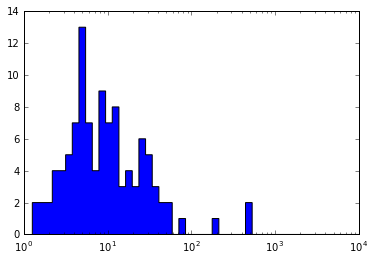

,fwd,rew,diff
192.135.14.32,286.985869,-235.382464,522.368334
2001:760:4224:1::32,279.580993,-179.240845,458.821838
192.41.236.35,15.680707,223.070029,207.389322
134.61.24.193,-0.273207,72.340059,72.613266
134.158.150.245,5.885383,59.511259,53.625877


In [9]:
# Look for the worst
dOWDs = differentialOWDs(data)
dOWDs.head()

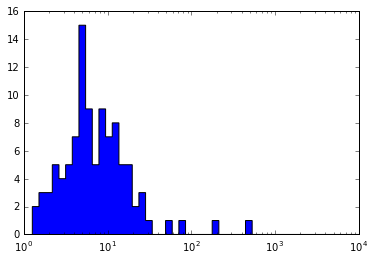

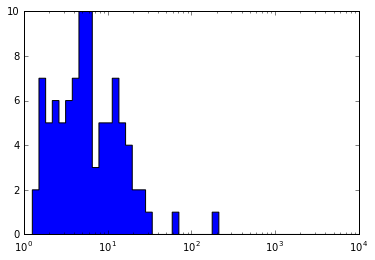

,fwd,rew,diff
192.41.236.35,15.680707,223.070029,207.389322
192.101.161.186,65.866828,-0.981836,66.848664
134.75.125.241,114.500350,148.214912,33.714562
202.13.203.129,65.406361,90.198270,24.791908
72.36.96.15,40.644650,16.344329,24.300322


In [10]:
#remove worst
data=data[data.src!='2001:760:4224:1::32']
data=data[data.dest!='2001:760:4224:1::32']

dOWDs = differentialOWDs(data)
dOWDs.head()

data=data[data.src!='192.135.14.32']
data=data[data.dest!='192.135.14.32']

dOWDs = differentialOWDs(data)
dOWDs.head()

# data=data[data.src!='128.211.143.3']
# data=data[data.dest!='128.211.143.3']

# dOWDs = differentialOWDs(data)
# dOWDs.head()

# data=data[data.src!='192.41.236.35']
# data=data[data.dest!='192.41.236.35']

# dOWDs = differentialOWDs(data)
# dOWDs.head(10)

In [11]:
data[data.src=='192.101.161.186']

,dest,dist,docs,owd,src
5430,134.158.150.245,965.646881,405,40.770304,192.101.161.186
5431,134.158.73.243,965.646881,405,50.280219,192.101.161.186
5432,192.101.107.152,8474.709813,405,120.439457,192.101.161.186
5433,134.61.24.193,1431.838722,404,49.152823,192.101.161.186
5434,18.12.1.171,5473.001960,404,80.566078,192.101.161.186
5435,193.206.93.45,1436.421997,404,53.992086,192.101.161.186


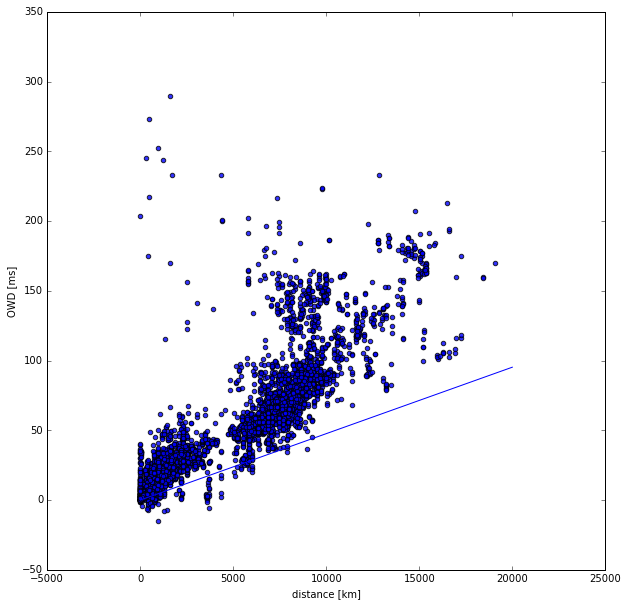

In [12]:
plt.figure(figsize=[10, 10])
plt.scatter( data.dist, data.owd ,alpha=0.8)
x = np.linspace(0, 20000)
y = x/(300*0.7)
plt.plot(x, y, '-')
plt.xlabel('distance [km]')
plt.ylabel('OWD [ms]')
plt.show()

In [13]:
# look for very low speeds
data1=data[data.dist>0]
data1['speed']=data1.dist/data1.owd/300
grouped = data1.groupby('src')
grouped.agg({'dist' : 'mean', 'speed':'mean', 'owd' : ['mean','count'] })
grouped.head()

src=[]
spd=[]
for name, group in grouped:
    #print(name, group.owd.mean())
    src.append(name)
    spd.append(group.speed.mean())
spdDF=pd.DataFrame({'spd':spd},index=src)
spdDF=spdDF.sort_values('spd')
spdDF.head()


/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,spd
194.85.69.74,-1.484922
212.193.96.29,-0.498684
188.185.224.217,0.002337
198.124.252.126,0.004922
134.158.150.245,0.005415


In [14]:
data[data.src=='128.211.143.3']

,dest,dist,docs,owd,src
5289,200.17.30.135,6497.569212,413,79.660038,128.211.143.3
5290,192.111.108.112,475.951715,410,15.703467,128.211.143.3
5291,128.227.221.44,1268.656758,409,17.633580,128.211.143.3
5292,200.136.80.20,6497.569212,408,91.221478,128.211.143.3
5293,131.225.205.12,198.493479,406,3.849403,128.211.143.3
5294,144.92.180.75,360.238859,406,5.718870,128.211.143.3
5295,169.228.130.40,2816.821244,406,30.762679,128.211.143.3
5296,129.93.239.148,823.967623,405,12.261262,128.211.143.3
5297,18.12.1.171,1334.994438,403,17.307610,128.211.143.3


In [15]:
data[data.src=='132.230.202.235']

,dest,dist,docs,owd,src
5457,193.170.243.215,417.283076,125,28.701061,132.230.202.235
5458,134.158.150.245,335.970772,122,-6.689765,132.230.202.235
5459,193.206.93.45,693.676706,122,23.283892,132.230.202.235
5460,134.158.73.243,335.970772,120,5.614766,132.230.202.235
5462,192.101.107.152,8345.371191,119,80.768704,132.230.202.235
5463,192.101.161.186,1297.569558,119,-7.693579,132.230.202.235
5464,134.61.24.193,333.056947,118,4.948479,132.230.202.235
5465,134.219.225.13,714.149027,116,19.992020,132.230.202.235
5466,18.12.1.171,5945.415565,114,49.487674,132.230.202.235
